In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import operator
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import imageio

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

import gym

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
"""
Dueling QNetwork for function aproximation. Splits the network prior to the end into two streams V and Q. 
V is the estimate of the value of the state. Q is the advantage of each action given the state.
Two formulations for subtracting Q from V:
V - max(Q)
This verision makes more sense theoretically as the value of V* should equal the max(Q*(s,A)). 
But in practice mean allows for better performance.
V - mean(Q)
Same as max except now they are separated by a constant. 
And not as susceptable to over optimism due to randomness of Q values.
"""

# class Dueling_QNetwork(nn.Module):
#     def __init__(self,state_space,action_space,seed):
#         super(Dueling_QNetwork,self).__init__()
#         """
#         Rescale the last layer gradients by 1/sqrt(2)
#         clip gradients whose norms are <= 10
#         """
#         self.action_space = action_space
#         self.state_space = state_space
#         self.seed = torch.manual_seed(seed)

#         self.fc1 = nn.Linear(state_space,64)
#         self.fc2 = nn.Linear(64,32)
#         self.Qfc1 = nn.Linear(32,action_space)
#         self.Vfc1 = nn.Linear(32,1)

#     def forward(self,state):
#         x = state
#         if not isinstance(state,torch.Tensor):
#             x = torch.tensor(x,dtype=torch.float32) #device = self.device,
#             x = x.unsqueeze(0)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         a = F.relu(self.Qfc1(x))
#         v = F.relu(self.Vfc1(x))
#         # Max formulation
#         # q_max = torch.max(q)
#         # q.sub_(max)
#         # mean = torch.mean(a)
#         # q.sub_(mean)
#         # torch.add(q,v)
#         v = v.expand_as(a)
#         q = v + a - a.mean(1,keepdim=True).expand_as(a)
#         return q
    
class Dueling_QNetwork(nn.Module):
    def __init__(self,state_space,action_space,seed,hidden_dims=(32,32),activation_fc=F.relu):
        super(Dueling_QNetwork,self).__init__()
        self.activation_fc = activation_fc
        self.seed = torch.manual_seed(seed)
        print('hidden_dims',hidden_dims)
        self.input_layer = nn.Linear(state_space,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.value_output = nn.Linear(hidden_dims[-1],1)
        self.advantage_output = nn.Linear(hidden_dims[-1],action_space)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        a = self.advantage_output(x)
        v = self.value_output(x)
        v = v.expand_as(a)
        q = v + a - a.mean(1,keepdim=True).expand_as(a)
        return q
        

In [10]:
"""
Priority Tree.
3 tiered tree structure containing
Root node (Object. sum of all lower values)
Intermediate Node (Object. Root as parent, sums a given slice of the priority array)
Priority Array (Array of priorities, length buffer_size)

The number of Intermediate nodes is calculated by the buffer_size / batch_size.

I_episode: current episode of training

Index: is calculated by i_episode % buffer_size. This loops the index after exceeding the buffer_size.

Indicies: (List) of memory/priority entries

intermediate_dict: maps index to intermediate node. Since each Intermediate node is responsible 
for a given slice of the priority array, given a particular index, it will return the Intermediate node
'responsible' for that index.

## Functions:

Add:
Calculates the priority of each TD error -> (abs(TD_error)+epsilon)**alpha
Stores the priority in the Priority_array.
Updates the sum_tree with the new priority

Update_Priorities:
Updates the index with the latest priority of that sample. As priorities can change over training
for a particular experience

Sample:
Splits the current priority_array based on the number of entries, by the batch_size.
Returns the indicies of those samples and the priorities.

Propogate:
Propogates the new priority value up through the tree
"""

class PriorityTree(object):
    def __init__(self,buffer_size,batch_size,alpha,epsilon):
        self.alpha = alpha
        self.epsilon = epsilon
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.num_intermediate_nodes = round(buffer_size / batch_size)
        self.current_intermediate_node = 0
        self.root = Node(None)
        self.intermediate_nodes = [Intermediate(self.root,batch_size*x,batch_size*(x+1)) for x in range(self.num_intermediate_nodes)]
        self.priority_array = np.zeros(buffer_size)
        self.intermediate_dict = {}
        for index,node in enumerate(self.intermediate_nodes):
            for key in range((batch_size*(index+1))-batch_size,batch_size*(index+1)):
                self.intermediate_dict[key] = node
        print('Priority Tree: Batch Size {} Buffer size {} Number of intermediate Nodes {}'.format(batch_size,buffer_size,self.num_intermediate_nodes))
        
    def add(self,TD_error,index):
        priority = (abs(TD_error)+self.epsilon)**self.alpha
        self.priority_array[index] = priority
        # Update sum
        propogate(self.intermediate_dict[index],self.priority_array)
    
    def sample(self,index):
        # Sample one experience uniformly from each slice of the priorities
        if index >= self.buffer_size:
            indicies = [random.sample(list(range(sample*self.num_intermediate_nodes,(sample+1)*self.num_intermediate_nodes)),1)[0] for sample in range(self.batch_size)]
        else:
            interval = int(index / self.batch_size)
            indicies = [random.sample(list(range(sample*interval,(sample+1)*interval)),1)[0] for sample in range(self.batch_size)]
#         print('indicies',indicies)
        priorities = self.priority_array[indicies]
        return priorities,indicies
    
    def update_priorities(self,TD_errors,indicies):
#         print('TD_errors',TD_errors)
#         print('TD_errors shape',TD_errors.shape)
        priorities = (abs(TD_errors)+self.epsilon)**self.alpha
#         print('priorities shape',priorities.shape)
#         print('indicies shape',len(indicies))
#         print('self.priority_array shape',self.priority_array.shape)
        self.priority_array[indicies] = priorities
        # Update sum
        nodes = [self.intermediate_dict[index] for index in indicies] 
        intermediate_nodes = set(nodes)
        [propogate(node,self.priority_array) for node in intermediate_nodes]
    
class Node(object):
    def __init__(self,parent):
        self.parent = parent
        self.children = []
        self.value = 0
            
    def add_child(self,child):
        self.children.append(child)
    
    def set_value(self,value):
        self.value = value
    
    def sum_children(self):
        return sum([child.value for child in self.children])
            
    def __len__(self):
        return len(self.children)

class Intermediate(Node):
    def __init__(self,parent,start,end):
        self.parent = parent
        self.start = start
        self.end = end
        self.value = 0
        parent.add_child(self)
    
    def sum_leafs(self,arr):
        return np.sum(arr[self.start:self.end])

def propogate(node,arr):
    if node.parent != None:
        node.value = node.sum_leafs(arr)
        propogate(node.parent,arr)
    else:
        node.value = node.sum_children()

In [11]:
"""
Priority Buffer HyperParameters
alpha(priority or w) dictates how biased the sampling should be towards the TD error. 0 < a < 1
beta(IS) informs the importance of the sample update

The paper uses a sum tree to calculate the priority sum in O(log n) time. As such, i've implemented my own version
of the sum_tree which i call priority tree.

We're increasing beta(IS) from 0.5 to 1 over time
alpha(priority) we're holding constant at 0.5
"""

class PriorityReplayBuffer(object):
    def __init__(self,action_size,buffer_size,batch_size,seed,alpha=0.5,beta=0.5,beta_end=1,beta_duration=1e+5,epsilon=7e-5):
        
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        self.beta_end = beta_end
        self.beta_duration = beta_duration
        self.beta_increment = (beta_end - beta) / beta_duration
        self.max_w = 0
        self.epsilon = epsilon
        self.TD_sum = 0

        self.experience = namedtuple('experience',field_names=['state','action','reward','next_state','done','i_episode'])
        self.sum_tree = PriorityTree(buffer_size,batch_size,alpha,epsilon)
        self.memory = {}
    
    def add(self,state,action,reward,next_state,done,TD_error,i_episode):
        e = self.experience(state,action,reward,next_state,done,i_episode)
        index = i_episode % self.buffer_size
        # add memory to memory and add corresponding priority to the priority tree
        self.memory[index] = e
        self.sum_tree.add(TD_error,index)

    def sample(self,index):
        # We times the error by these weights for the updates
        # Super inefficient to sum everytime. We could implement the tree sum structure. 
        # Or we could sum once on the first sample and then keep track of what we add and lose from the buffer.
        # priority^a over the sum of the priorities^a = likelyhood of the given choice
        # Anneal beta
        self.update_beta()
        # Get the samples and indicies
        priorities,indicies = self.sum_tree.sample(index)
        # Normalize with the sum
        norm_priorities = priorities / self.sum_tree.root.value
        samples = [self.memory[index] for index in indicies]
#         samples = list(operator.itemgetter(*self.memory)(indicies))
#         samples = self.memory[indicies]
        # Importance weights
#         print('self.beta',self.beta)
#         print('self.beta',self.buffer_size)
        importances = [(priority * self.buffer_size)**-self.beta for priority in norm_priorities]
        self.max_w = max(self.max_w,max(importances))
        # Normalize importance weights
#         print('importances',importances)
#         print('self.max_w',self.max_w)
        norm_importances = [importance / self.max_w for importance in importances]
#         print('norm_importances',norm_importances)
        states = torch.from_numpy(np.vstack([e.state for e in samples if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in samples if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in samples if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in samples if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in samples if e is not None])).float().to(device)
        
        if index % 4900 == 0:
            print('beta',self.beta)
            print('self.max_w',self.max_w)
            print('len mem',len(self.memory))
            print('tree sum',self.sum_tree.root.value)
        
        return (states,actions,rewards,next_states,dones),indicies,norm_importances

    def update_beta(self):
#         print('update_beta')
#         print('self.beta_end',self.beta_end)
#         print('self.beta_increment',self.beta_increment)
        self.beta += self.beta_increment
        self.beta = min(self.beta,self.beta_end)
    
    def __len__(self):
        return len(self.memory.keys())

In [12]:
"""
DQN with Priority Replay, DDQN, and Dueling DQN.
"""
class Priority_DQN(object):
    def __init__(self,state_space,action_space,seed,update_every,batch_size,buffer_size,min_buffer_size,learning_rate,GAMMA,tau,clip_norm,alpha):
        self.action_space = action_space
        self.state_space = state_space
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.min_buffer_size = min_buffer_size
        self.learning_rate = learning_rate
        self.update_every = update_every
        self.GAMMA = GAMMA
        self.alpha = alpha
        self.tau = tau
        self.clip_norm = clip_norm
        
        self.qnetwork_local = Dueling_QNetwork(state_space,action_space,seed)
        self.qnetwork_target = Dueling_QNetwork(state_space,action_space,seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=learning_rate)
        # Initialize replaybuffer
        self.memory = PriorityReplayBuffer(action_space,buffer_size,batch_size,seed,alpha)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self,state,action,reward,next_state,done,index):
        # Calculate TD error
        # Target
        current_network_action = self.qnetwork_local(next_state).max(1)[1]
        # initial state comes in as (1,4), squeeze to get (4)
        target = reward + self.GAMMA*(self.qnetwork_target(next_state).squeeze(0)[current_network_action])
        # Local. same rational for squeezing
        local = self.qnetwork_local(state).squeeze(0)[action]
        TD_error = reward + target - local
        # Save the experience
        self.memory.add(state,action,reward,next_state,done,TD_error,index)
        
        # learn from the experience
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.min_buffer_size:
                experiences,indicies,weights = self.memory.sample(index)
                self.learn(experiences,indicies,weights)
        
    def act(self,state,eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_space))
        
    def learn(self,experiences,indicies,weights):
        
        states,actions,rewards,next_states,dones = experiences
        # Local max action
        local_next_state_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        # Target
        target_values = self.qnetwork_target(next_states).detach()
        max_target = target_values.gather(1,local_next_state_actions)
#         print('max_target size',max_target.size())
        max_target *= (1-dones) 
        targets = rewards + (self.GAMMA*max_target)
#         print('targets',targets.size())
#         targets = rewards + self.GAMMA*(target_values.gather(1,local_next_state_actions))
        # Local
        local = self.qnetwork_local(states).gather(1,actions)
        TD_error = local - targets
        loss = ((torch.tensor(weights) * TD_error)**2*0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(),self.clip_norm)
        self.optimizer.step()
        # Update the priorities
        TD_errors = np.abs(TD_error.squeeze(1).detach().cpu().numpy())
        self.memory.sum_tree.update_priorities(TD_errors,indicies)
        self.update_target()

    # def update_target(self,tau):
    #     for local_param,target_param in zip(self.qnetwork_local.parameters(),self.qnetwork_target.parameters()):
    #         target_param.data.copy_(local_param.data)
        
    # Polyak averaging  
    def update_target(self):
        for local_param,target_param in zip(self.qnetwork_local.parameters(),self.qnetwork_target.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1-self.tau)*target_param.data)
#         self.qnetwork_local.parameters() = TAU*self.qnetwork_local.parameters() + (1-TAU)*self.qnetwork_target.parameters()

In [24]:
def train(agent,env,n_episodes=1800, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        Instead of updating target every (int) steps, using Polyak updating of .1 to gradually merge the networks
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    index = 0
    for i_episode in range(1,n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done,_ = env.step(action)
            agent.step(state,action,reward,next_state,done,index)
            state = next_state
            score += reward
            index += 1
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps*eps_decay,eps_end)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

# Initialize Hyperparameters 

In [25]:
BUFFER_SIZE = 10000
MIN_BUFFER_SIZE = 200
BATCH_SIZE = 50
ALPHA = 0.6 # 0.7 or 0.6
START_BETA = 0.5 # from 0.5-1
END_BETA = 1
LR = 0.00025
EPSILON = 1
MIN_EPSILON = 0.01
GAMMA = 0.99
TAU = 0.01
UPDATE_EVERY = 4
CLIP_NORM = 10

# Train the Agent

Observation Space 8, Action Space 4
hidden_dims (32, 32)
hidden_dims (32, 32)
Priority Tree: Batch Size 50 Buffer size 10000 Number of intermediate Nodes 200
Episode 100	Average Score: -203.78
Episode 200	Average Score: -136.94
Episode 300	Average Score: -109.88
Episode 400	Average Score: -69.796
Episode 500	Average Score: -18.93
Episode 600	Average Score: -23.29
Episode 700	Average Score: 44.888
Episode 800	Average Score: 23.80
Episode 900	Average Score: 125.57
Episode 991	Average Score: 200.82
Environment solved in 991 episodes!	Average Score: 200.82


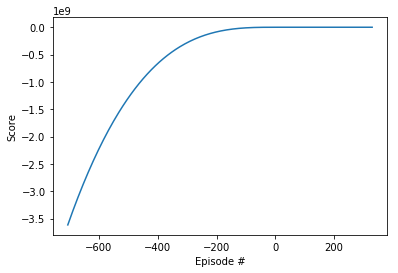

<Figure size 432x288 with 0 Axes>

In [26]:
# def main():
env = gym.make('LunarLander-v2')
env.seed(0)
nA = env.action_space.n
nS = env.observation_space.shape[0]
print('Observation Space {}, Action Space {}'.format(nS,nA))
seed = 7
agent = Priority_DQN(nS,nA,seed,UPDATE_EVERY,BATCH_SIZE,BUFFER_SIZE,MIN_BUFFER_SIZE,LR,GAMMA,TAU,CLIP_NORM,ALPHA)

scores = train(agent,env)
# main()

# Plot the scores

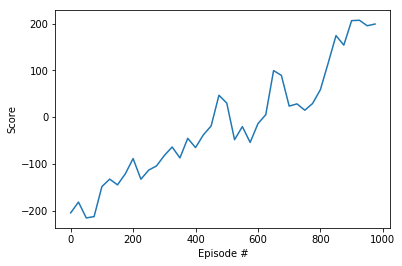

In [76]:
import math
# Rolling mean plot
interval = 25
rolling_mean = [np.mean(scores[(slice_*interval):(slice_+1)*interval]) for slice_ in range(math.ceil(len(scores)/interval))]
x_axis = np.arange(len(rolling_mean)) * interval
plt.plot(x_axis, rolling_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('test'+ str(j)+'.png',bbox_inches='tight')

# Visualize the bot in the environment

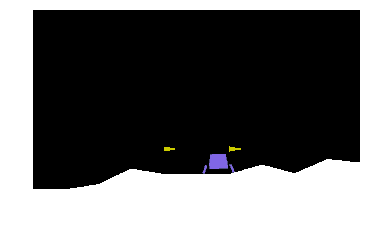

In [45]:
try:
    # load the weights from file
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
except:  
    # Else reinstantiate the environment and other variables
    env = gym.make('LunarLander-v2')
    env.seed(0)
    nA = env.action_space.n
    nS = env.observation_space.shape[0]
    seed = 7
    agent = Priority_DQN(nS,nA,seed,UPDATE_EVERY,BATCH_SIZE,BUFFER_SIZE,MIN_BUFFER_SIZE,LR,GAMMA,TAU,CLIP_NORM,ALPHA)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    

for i in range(1):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(500):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        # save the image
        plt.savefig('test'+ str(j)+'.png',bbox_inches='tight')
        
        if done:
            break 
            
env.close()

# Make GIF from stored sequence of images

In [46]:
import os
# Make gif from images
path = '/Users/morgan/RL_gif_images'
images = []
filenames = ['test' + str(i) + '.png' for i in range(500)]
for filename in filenames:
    images.append(imageio.imread(path +'/'+ filename))
imageio.mimsave('RL_movie.gif', images)